# Assignment-1
## Team: Aditya Ahuja (2020275), Deeptanshu Barman Chowdhuri (2020293)

##  Imports & Dataset

In [ ]:
!pip install torchmetrics
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 51.9 MB/s eta 0:00:00


In [11]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import random_split
import lightning as L
import torchmetrics

In [12]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# device = "cpu"


In [ ]:
Noise_0_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_syn_train_0_0_.csv"
)
Noise_Low_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_synA_train_shuffled.csv"
)
Noise_High_data = requests.get(
    "http://AdityaAhuja01.pythonanywhere.com/data/df_synA_test_hard_shuffled_sample.csv"
)

if Noise_0_data.status_code == 200 and Noise_Low_data.status_code == 200 and Noise_High_data.status_code == 200:
    datafolder = "Data/Assignment1"

    if not os.path.exists(datafolder):
        os.makedirs(datafolder)

    with open(os.path.join(datafolder, "data_0_noise"), "wb") as f:
        f.write(Noise_0_data.text.encode("utf-8"))

    with open(os.path.join(datafolder, "data_Low_noise"), "wb") as f:
        f.write(Noise_Low_data.text.encode("utf-8"))

    with open(os.path.join(datafolder, "data_High_noise"), "wb") as f:
        f.write(Noise_High_data.text.encode("utf-8"))
else:
    print("Error in fetching data")

In [13]:
Noise_0_dataframe = pd.read_csv("Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("Data/Assignment1/data_High_noise")

In [14]:
class_index = list(Noise_0_dataframe["era"].unique())
class_index_noise = list(Noise_Low_dataframe["era"].unique())
def encode(value, class_index = class_index):
    return class_index.index(value)

def encode_noise(value, class_index = class_index_noise):
    return class_index.index(value)

Noise_0_dataframe["era"] = Noise_0_dataframe["era"].apply(encode)
Noise_Low_dataframe["era"] = Noise_Low_dataframe["era"].apply(encode_noise)
Noise_Low_dataframe["era"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

## Setting up Dataset & Dataloaders

In [15]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None,drop = None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        self.y = dataframe["era"].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise


In [16]:
#Setting up datasets
Noise_0_dataset = CustomDataset(Noise_0_dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val"])
Noise_Low_dataset = CustomDataset(Noise_Low_dataframe, "Low", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"])
Noise_High_dataset = CustomDataset(Noise_High_dataframe, "High", drop = ["row_num","day","era","target_10_val","target_5_val","data_type"])
Noise_0_train, Noise_0_test = random_split(Noise_0_dataset, [int(0.8 * len(Noise_0_dataset)), len(Noise_0_dataset) - int(0.8 * len(Noise_0_dataset))])
Noise_Low_train, Noise_Low_test = random_split(Noise_Low_dataset, [int(0.8 * len(Noise_Low_dataset)), len(Noise_Low_dataset) - int(0.8 * len(Noise_Low_dataset))])
Noise_High_train, Noise_High_test = random_split(Noise_High_dataset, [int(0.8 * len(Noise_High_dataset)), len(Noise_High_dataset) - int(0.8 * len(Noise_High_dataset))])

In [17]:
#Setting up dataloaders
Noise_0_train_loader = DataLoader(Noise_0_train, batch_size=64, shuffle=True)
Noise_0_test_loader = DataLoader(Noise_0_test, batch_size=64, shuffle=True)
Noise_Low_train_loader = DataLoader(Noise_Low_train, batch_size=256, shuffle=True)
Noise_Low_test_loader = DataLoader(Noise_Low_test, batch_size=256, shuffle=True)
Noise_High_train_loader = DataLoader(Noise_High_train, batch_size=64, shuffle=True)
Noise_High_test_loader = DataLoader(Noise_High_test, batch_size=64, shuffle=True)

## Model

In [9]:
class MyMLP(torch.nn.Module):
    def __init__ (self, modules):
        super().__init__()
        self.relu = torch.nn.ReLU()
        MyModuleList = torch.nn.ModuleList([m for m in modules])
        self.layers = torch.nn.Sequential(*MyModuleList)
        self.softmax = torch.nn.Softmax(dim = 1)


    def forward(self, X: torch.Tensor):
        if (X.shape[1] != 24):
            raise ValueError("Input shape must be (batch_size, 24)")
        X = X.to(device)
        X = self.layers(X)
        X = self.softmax(X)

        return X

In [7]:
# Import the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchmetrics

# Define the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the dataset class
class Dataset(data.Dataset):
  # Your code here
  pass

# Define the model class
class Model(nn.Module):
  # Your code here
  pass

# Define the ensemble classifier class
class EnsembleClassifier():
  def __init__(self, Dataset, num_classifiers, sample_percentage = 0.8):
    # Initialize the ensemble
    self.Dataset = Dataset
    self.sample_percentage = sample_percentage
    self.num_classifiers = num_classifiers
    self.models = torch.nn.ModuleList()

    # Create different models for each classifier
    for clf in range(num_classifiers):
      # You can use different architectures, hyperparameters, or dropout rates for each model
      # Here I just use a simple linear model with a random number of features
      num_features = torch.randint(10, 100, (1,)).item()
      model = Model(num_features).to(device)
      self.models.append(model)

  def train(self, criterion, optimizer, batchsize, num_epochs):
    # Get the number of samples in the dataset
    num_samples = len(self.Dataset)
    # Create a list of bootstrap dataloaders for each classifier
    bootstrap_dataloaders = []
    for c in range(self.num_classifiers):
      # Create a weighted random sampler with replacement
      weights = torch.ones(num_samples)
      sampler = data.WeightedRandomSampler(weights, int(num_samples * self.sample_percentage), replacement=True)
      # Create a dataloader with the sampler
      sampled_dataloader = data.DataLoader(self.Dataset, batch_size = batchsize, sampler=sampler)
      bootstrap_dataloaders.append(sampled_dataloader)

    # Create a metric to compute the accuracy of each classifier and the ensemble
    accuracy = torchmetrics.Accuracy().to(device)

    # Train the ensemble
    for epoch in range(num_epochs):
      print("Starting Epoch-", epoch)
      # Initialize the epoch losses and accuracies
      epoch_losses = torch.zeros(self.num_classifiers)
      epoch_accuracies = torch.zeros(self.num_classifiers)
      # Train each classifier
      for model_num in range(len(self.models)):
        # Set the model to train mode
        self.models[model_num].train()
        # Loop over the bootstrap dataloader
        for inputs, labels in bootstrap_dataloaders[model_num]:
          # Move the inputs and labels to the device
          inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
          # Zero the parameter gradients
          optimizer.zero_grad()
          # Forward pass
          outputs = self.modelsmodel_num
          # Compute the loss
          loss = criterion(outputs, labels)
          # Backward pass and optimize
          loss.backward()
          optimizer.step()
          # Update the epoch loss
          epoch_losses[model_num] += loss.item()
          # Update the epoch accuracy
          epoch_accuracies[model_num] += accuracy(outputs, labels)
        # Compute the average epoch loss and accuracy
        epoch_losses[model_num] /= len(bootstrap_dataloaders[model_num])
        epoch_accuracies[model_num] /= len(bootstrap_dataloaders[model_num])
        # Print the epoch loss and accuracy for each classifier
        print(f"Classifier {model_num}: Loss = {epoch_losses[model_num]:.4f}, Accuracy = {epoch_accuracies[model_num]:.4f}")
      # Compute the ensemble accuracy by averaging the predictions of each classifier
      ensemble_accuracy = 0
      # Loop over the original dataloader
      for inputs, labels in data.DataLoader(self.Dataset, batch_size = batchsize):
        # Move the inputs and labels to the device
        inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
        # Initialize the ensemble predictions
        ensemble_predictions = torch.zeros(inputs.size(0), device=device)
        # Loop over each classifier
        for model_num in range(len(self.models)):
          # Set the model to eval mode
          self.models[model_num].eval()
          # Forward pass
          outputs = self.modelsmodel_num
          # Get the predictions
          predictions = torch.argmax(outputs, dim=1)
          # Add the predictions to the ensemble predictions
          ensemble_predictions += predictions
        # Get the majority vote of the ensemble predictions
        ensemble_predictions = torch.round(ensemble_predictions / self.num_classifiers)
        # Update the ensemble accuracy
        ensemble_accuracy += accuracy(ensemble_predictions, labels)
      # Compute the average ensemble accuracy
      ensemble_accuracy /= len(data.DataLoader(self.Dataset, batch_size = batchsize))
      # Print the ensemble accuracy
      print(f"Ensemble: Accuracy = {ensemble_accuracy:.4f}")


c:\Anaconda\envs\amlenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class EnsembleClassifier():
  def __init__(self, Dataset, num_classifiers,sample_percentage = 0.8):
    self.Dataset = Dataset
    self.sample_percentage = sample_percentage
    self.num_classifiers = num_classifiers
    self.models = torch.nn.ModuleList()

    #Currently hard coded the model, change later
    for clf in range(num_classifiers):
      self.models.append(MyMLP([torch.nn.Linear(24,64),torch.nn.ReLU(),torch.nn.Linear(64,128),torch.nn.Dropout(p = 0.2),torch.nn.ReLU(),torch.nn.Linear(128,64),torch.nn.Dropout(p = 0.2),torch.nn.ReLU(),torch.nn.Linear(64,12)]).to(device))

  def train(self,criterion,batchsize,num_epochs):
      num_samples = int(0.8 * len(self.Dataset))
      indices = list(range(num_samples))
      bootstrap_dataloaders = []
      accuracy = torchmetrics.Accuracy(task = "multiclass",num_classes = 12).to(device)

      for c in range(self.num_classifiers):
          sampled_indices = torch.randperm(num_samples)[:int(num_samples * self.sample_percentage)]
          sampler = SubsetRandomSampler(sampled_indices)
          sampled_dataloader = DataLoader(self.Dataset, batch_size = batchsize, sampler=sampler)
          bootstrap_dataloaders.append(sampled_dataloader)

      for epoch in range(num_epochs):
        print("Starting Epoch-",epoch)
        epoch_losses = torch.zeros(self.num_classifiers).to(device)
        epoch_accuracies = torch.zeros(self.num_classifiers).to(device)
        for model_num in range(len(self.models)):
          optimizer = optim.Adam(self.models[model_num].parameters(), lr=0.0001, weight_decay=0.001)
          self.models[model_num].train()
          for inputs, labels in bootstrap_dataloaders[model_num]:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            optimizer.zero_grad()
            outputs = self.models[model_num](inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_losses[model_num] += loss.item()
            epoch_accuracies[model_num] += accuracy(outputs, labels)

          epoch_losses[model_num] /= len(bootstrap_dataloaders[model_num])
          epoch_accuracies[model_num] /= len(bootstrap_dataloaders[model_num])
          print(f"Classifier {model_num}: Loss = {epoch_losses[model_num]:.4f}, Accuracy = {epoch_accuracies[model_num]:.4f}")

  def forward(self, x):
    ensemble_predictions = torch.zeros(x.size(0), 12, device=device)
    for model_num in range(len(self.models)):
      self.models[model_num].eval()
      outputs = self.models[model_num](x)
      ensemble_predictions += outputs
    ensemble_predictions /= self.num_classifiers
    return ensemble_predictions










In [ ]:
Model = MyMLP([torch.nn.Linear(24,64),torch.nn.ReLU(),torch.nn.Linear(64,128),torch.nn.Dropout(p = 0.2),torch.nn.ReLU(),torch.nn.Linear(128,64),torch.nn.Dropout(p = 0.2),torch.nn.ReLU(),torch.nn.Linear(64,12)])
Model = Model.to(device)

In [11]:
Ensemble = EnsembleClassifier(Noise_Low_dataset,5,0.7)
Ensemble.train(torch.nn.CrossEntropyLoss(),128,10)

Starting Epoch- 0
Classifier 0: Loss = 2.4328, Accuracy = 0.1635
Classifier 1: Loss = 2.4332, Accuracy = 0.1657
Classifier 2: Loss = 2.4344, Accuracy = 0.1598
Classifier 3: Loss = 2.4284, Accuracy = 0.1853
Classifier 4: Loss = 2.4329, Accuracy = 0.1761
Starting Epoch- 1
Classifier 0: Loss = 2.3595, Accuracy = 0.2601
Classifier 1: Loss = 2.3575, Accuracy = 0.2638
Classifier 2: Loss = 2.3604, Accuracy = 0.2602
Classifier 3: Loss = 2.3584, Accuracy = 0.2605
Classifier 4: Loss = 2.3619, Accuracy = 0.2573
Starting Epoch- 2
Classifier 0: Loss = 2.3447, Accuracy = 0.2734
Classifier 1: Loss = 2.3383, Accuracy = 0.2797
Classifier 2: Loss = 2.3434, Accuracy = 0.2744
Classifier 3: Loss = 2.3416, Accuracy = 0.2748
Classifier 4: Loss = 2.3468, Accuracy = 0.2709
Starting Epoch- 3
Classifier 0: Loss = 2.3354, Accuracy = 0.2789
Classifier 1: Loss = 2.3001, Accuracy = 0.3216
Classifier 2: Loss = 2.3282, Accuracy = 0.2871
Classifier 3: Loss = 2.3185, Accuracy = 0.2996
Classifier 4: Loss = 2.3390, Accura

In [ ]:
for input,label in Noise_Low_test_loader:
  input, label = input.to(device).to(torch.float32), label.to(device).to(torch.long)
  outputs = Ensemble.forward(input)
  predicted_labels = torch.argmax(outputs, dim=1)
  print((predicted_labels == label).sum()/256)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


Epoch [1/100], Train Loss: 2.1665, Train Acc: 0.4598, Val Loss: 2.0659, Val Acc: 0.5568
Epoch [2/100], Train Loss: 2.0517, Train Acc: 0.5720, Val Loss: 2.0280, Val Acc: 0.5948
Epoch [3/100], Train Loss: 2.0327, Train Acc: 0.5901, Val Loss: 2.0134, Val Acc: 0.6078
Epoch [4/100], Train Loss: 2.0155, Train Acc: 0.6080, Val Loss: 1.9584, Val Acc: 0.6662
Epoch [5/100], Train Loss: 1.9600, Train Acc: 0.6642, Val Loss: 1.9402, Val Acc: 0.6810
Epoch [6/100], Train Loss: 1.9300, Train Acc: 0.6951, Val Loss: 1.9033, Val Acc: 0.7201
Epoch [7/100], Train Loss: 1.9160, Train Acc: 0.7083, Val Loss: 1.8943, Val Acc: 0.7278
Epoch [8/100], Train Loss: 1.9067, Train Acc: 0.7174, Val Loss: 1.8927, Val Acc: 0.7304
Epoch [9/100], Train Loss: 1.9004, Train Acc: 0.7240, Val Loss: 1.8859, Val Acc: 0.7350
Epoch [10/100], Train Loss: 1.8969, Train Acc: 0.7269, Val Loss: 1.8754, Val Acc: 0.7474
Epoch [11/100], Train Loss: 1.8916, Train Acc: 0.7325, Val Loss: 1.8774, Val Acc: 0.7442
Epoch [12/100], Train Loss: 1.

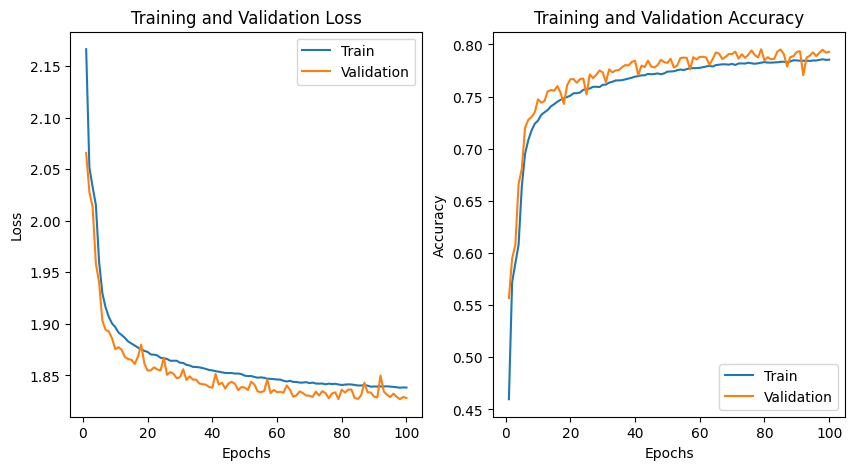

In [21]:
Model = MyMLP([torch.nn.Linear(24,64),torch.nn.ReLU(),torch.nn.Linear(64,256),torch.nn.Dropout(p = 0.2),torch.nn.ReLU(),torch.nn.Linear(256,64),torch.nn.Dropout(p = 0.2),torch.nn.ReLU(),torch.nn.Linear(64,12)]).to(device)
optimizer = optim.Adam(Model.parameters(), lr=0.001, weight_decay=0.0001)
train_model(Model,torch.nn.CrossEntropyLoss(), optimizer,Noise_Low_train_loader, Noise_Low_test_loader,num_epochs=100)

In [22]:
PATH = "model.pt"

# Save the model
torch.save(Model.state_dict(), PATH)

In [23]:
PATH = "model.pt"

# Load the model
Model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Lightning

In [ ]:
from lightning.pytorch.utilities.types import OptimizerLRScheduler


class LightningMLP(L.LightningModule):
    def __init__(self, model, loss, optimizer):
        super().__init__()
        self.model = model
        self.loss = loss
        self.optimizer = optimizer

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        inputs, targets = torch.tensor(inputs).to(torch.float32),torch.tensor(targets).to(torch.long)
        inputs, targets = inputs.to(device),targets.to(device)
        output = self.model(inputs)
        loss = self.loss(output, targets)
        self.log("train_loss", loss)
        return loss

    def test_step(self,batch,batch_idx):
        inputs, targets = batch
        inputs, targets = torch.tensor(inputs).to(torch.float32),torch.tensor(targets).to(torch.long)
        inputs, targets = inputs.to(device),targets.to(device)
        output = self.model(inputs)
        loss = self.loss(output, targets)
        self.log("train_loss", loss)
        return loss


    def configure_optimizers(self):
        return self.optimizer


In [ ]:
mymodel = LightningMLP(Model, torch.nn.CrossEntropyLoss, torch.optim.Adam(Model.parameters(), lr=0.001))
trainer = L.Trainer(max_epochs = 10)
trainer.fit(mymodel, Noise_0_train_loader, Noise_0_test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


C:\Users\Deeptanshu Barman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightning\pytorch\trainer\configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | MyMLP | 6.5 K 
--------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
C:\Users\Deeptanshu Barman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

C:\temp\ipykernel_16032\3998816417.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, targets = torch.tensor(inputs).to(torch.float32),torch.tensor(targets).to(torch.long)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous